In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

Number of rows with missing values: 0.0


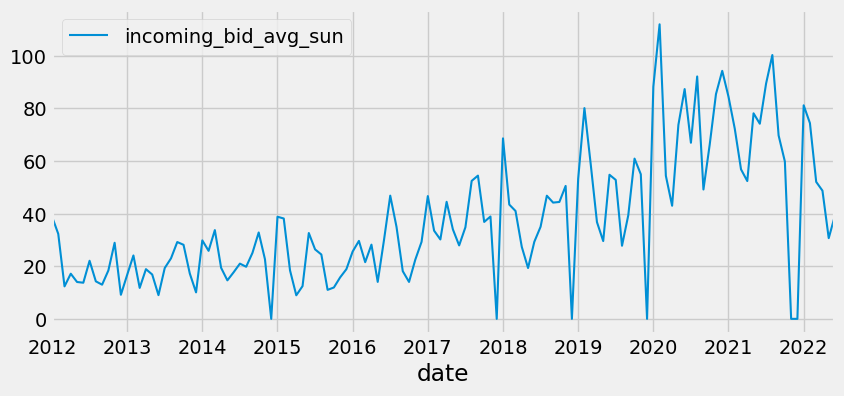

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

# Data preparation
# ==============================================================================
data = data.rename(columns={'month': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'incoming_bid_avg_sun': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='incoming_bid_avg_sun')
ax.legend();

In [3]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2012-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=114)
Test dates  : 2021-07-01 00:00:00 --- 2022-06-01 00:00:00  (n=12)


In [8]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 12
             )

forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
2021-07-01,70.308372,29.529927,106.185922
2021-08-01,75.676527,35.039784,107.744112
2021-09-01,61.856420,25.502462,103.292008
2021-10-01,65.439319,27.662944,102.290117
2021-11-01,81.397286,45.028637,112.230378


Test error (mse): 1940.6379232103855


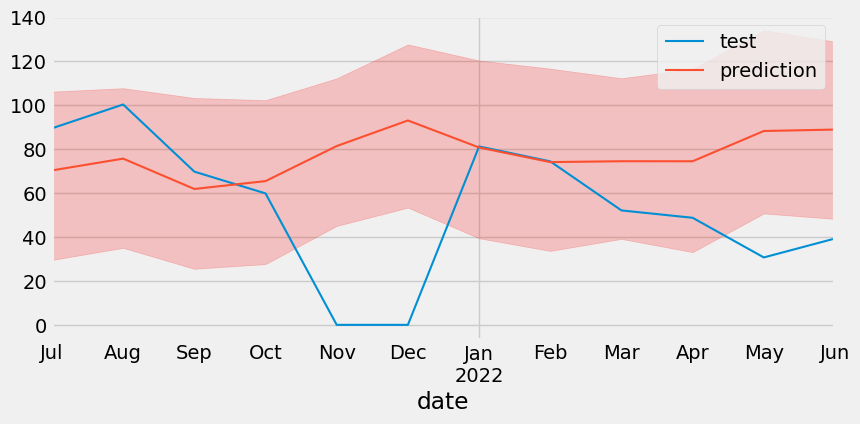

In [9]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();


Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2019-06-01 00:00:00  (n=90)
    Validation: 2019-07-01 00:00:00 -- 2020-06-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2020-06-01 00:00:00  (n=102)
    Validation: 2020-07-01 00:00:00 -- 2021-06-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2021-06-01 00:00:00  (n=114)
    Validation: 2021-07-01 00:00:00 -- 2022-06-01 00:00:00  (n=12)

Test error (mse): 1940.6379232103855


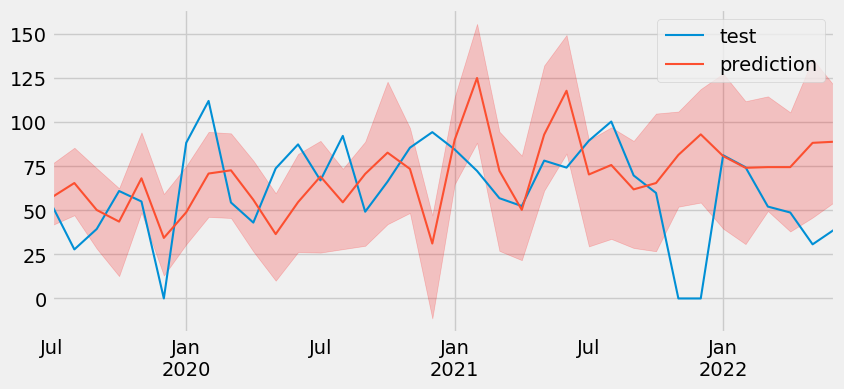

In [12]:
# Backtest with prediction intervals
# ==============================================================================
n_backtesting = 12*3 # The last 9 years are separated for backtesting
steps = 12
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 12
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                      )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions.index, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [13]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 58.33 %


In [14]:
# Custom metric 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [15]:
# Backtesting 
# ==============================================================================
steps = 12
n_backtesting = 12*3 # The last 9 years are separated for backtesting

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   2012-01-01 00:00:00 -- 2019-06-01 00:00:00  (n=90)
    Validation: 2019-07-01 00:00:00 -- 2020-06-01 00:00:00  (n=12)
Data partition in fold: 1
    Training:   2012-01-01 00:00:00 -- 2020-06-01 00:00:00  (n=102)
    Validation: 2020-07-01 00:00:00 -- 2021-06-01 00:00:00  (n=12)
Data partition in fold: 2
    Training:   2012-01-01 00:00:00 -- 2021-06-01 00:00:00  (n=114)
    Validation: 2021-07-01 00:00:00 -- 2022-06-01 00:00:00  (n=12)

Backtest error: 37.38405835702212


In [16]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

2022-07-01    42.554519
2022-08-01    38.785086
2022-09-01    25.654586
Freq: MS, Name: pred, dtype: float64

In [17]:
# Save model
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [18]:
# Load model
forecaster_loaded = load_forecaster('forecaster.py')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2022-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-28 08:39:57 
Last fit date: 2023-01-28 08:39:57 
Skforecast version: 0.6.0 
Python version: 3.10.8 



In [19]:
# Predict
forecaster_loaded.predict(steps=6)

2022-07-01    42.554519
2022-08-01    38.785086
2022-09-01    25.654586
2022-10-01    20.579934
2022-11-01    18.028461
2022-12-01    19.805173
Freq: MS, Name: pred, dtype: float64

In [20]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=data_train['y'])

In [21]:
last_window = data_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

2022-07-01    57.870677
2022-08-01    51.887267
2022-09-01    31.382142
2022-10-01    53.008778
Freq: MS, Name: pred, dtype: float64

In [24]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.6.2
numpy               1.23.5
pandas              1.5.2
session_info        1.0.0
skforecast          0.6.0
sklearn             1.1.3
-----
IPython             7.33.0
jupyter_client      7.4.8
jupyter_core        5.1.0
notebook            6.5.2
-----
Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]
macOS-13.1-arm64-arm-64bit
-----
Session information updated at 2023-01-28 08:44
